In [1]:
import sys,os,argparse,time
import numpy as np
import torch
import utils
from datetime import datetime
import pickle
import pandas as pd
tstart=time.time()
import matplotlib.pyplot as plt 
from tabulate import tabulate
from prettytable import PrettyTable

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Arguments
parser=argparse.ArgumentParser(description='xxx')
parser.add_argument('--seed',               default=0,                    type=int,     help='(default=%(default)d)')
parser.add_argument('--device',             default='cpu',                type=str,     help='gpu id')
parser.add_argument('--experiment',         default='16_task_groups',     type =str,    help='Mnist or dissertation')
parser.add_argument('--approach',           default='PUGCL',              type =str,    help='Method, always Lifelong Uncertainty-aware learning')
parser.add_argument('--data_path',          default='data/data_test.csv', type=str,     help='gpu id')

# Training parameters
parser.add_argument('--output',             default='',                           type=str,     help='')
parser.add_argument('--checkpoint_dir',     default='../checkpoints_16_tasks',    type=str,     help='')
parser.add_argument('--n_epochs',           default=100,                          type=int,     help='')
parser.add_argument('--batch_size',         default=64,                           type=int,     help='')
parser.add_argument('--lr',                 default=0.03,                         type=float,   help='')
parser.add_argument('--hidden_size',        default=800,                          type=int,     help='')
parser.add_argument('--parameter',          default='',                           type=str,     help='')

# UCB HYPER-PARAMETERS
parser.add_argument('--MC_samples',         default='10',           type=int,     help='Number of Monte Carlo samples')
parser.add_argument('--rho',                default='-3',           type=float,   help='Initial rho')
parser.add_argument('--sigma1',             default='0.0',          type=float,   help='STD foor the 1st prior pdf in scaled mixture Gaussian')
parser.add_argument('--sigma2',             default='6.0',          type=float,   help='STD foor the 2nd prior pdf in scaled mixture Gaussian')
parser.add_argument('--pi',                 default='0.25',         type=float,   help='weighting factor for prior')

parser.add_argument('--resume',             default='no',           type=str,     help='resume?')
parser.add_argument('--sti',                default=1,              type=int,     help='starting task?')

parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

args=parser.parse_args()
utils.print_arguments(args)

Arguments =
	seed: 0
	device: cpu
	experiment: 16_task_groups
	approach: PUGCL
	data_path: data/data_test.csv
	output: 
	checkpoint_dir: ../checkpoints_16_tasks
	n_epochs: 100
	batch_size: 64
	lr: 0.03
	hidden_size: 800
	parameter: 
	MC_samples: 10
	rho: -3.0
	sigma1: 0.0
	sigma2: 6.0
	pi: 0.25
	resume: no
	sti: 1
	fff: /Users/jonastjomsland/Library/Jupyter/runtime/kernel-3d446126-a62c-4afd-9de0-147b298c5635.json


In [4]:
# Set seed for stable results
#np.random.seed(args.seed)
#torch.manual_seed(args.seed)

# Check if Cuda is available
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Using device:", args.device)

# PUGCL with two tasks:
from data import dataloader_16_tasks as dataloader

# Import Lifelong Uncertainty-aware Learning approach:
#from bayesian_model.lul import Lul
from training_method import PUGCL

# Import model used:
#from bayesian_model.bayesian_network import BayesianNetwork
from bayesian_model.bayesian_network2 import BayesianNetwork

# Load training data:
print("Loading data...")
data, task_outputs, input_size = dataloader.get(data_path='data/data.csv')
print("Input size =", input_size, "\nTask info =", task_outputs)
print("Number of data samples: ", len(data[0]['train']['x']))
args.num_tasks = len(task_outputs)
args.input_size = input_size
args.task_outputs = task_outputs

# Used to load best model:
args.approach = 'PUGCL_best'

# Hardcode hidden size from parameter search:
args.hidden_size = 800
task_order = [9, 15, 1, 8, 13, 5, 3, 11, 4, 7, 12, 10, 6, 2, 0, 14]

# Checkpoint for this run
checkpoint = utils.make_directories(args)
args.checkpoint = checkpoint
print(checkpoint)

# Initialize Bayesian network
print("Initializing network...")
model = BayesianNetwork(args).to(args.device)

# Initialize Lul approach
print("Initialize Lifelong Uncertainty-aware Learning")
approach = PUGCL(model, args=args)
print("-"*100)

# Load stored model:
# Need to read text file to see order of trained tasks!! In this case model 14 is the latest
model_number = 10
checkpoint = torch.load(os.path.join(args.checkpoint, 'model_{}.pth.tar'.format(model_number)), map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device=args.device).eval()

Using device: cpu
Loading data...
Input size = [1, 29] 
Task info = [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2)]
Number of data samples:  500
Results will be saved in  ../checkpoints_16_tasks/16_task_groups_PUGCL_best
../checkpoints_16_tasks/16_task_groups_PUGCL_best
Initializing network...
Initialize Lifelong Uncertainty-aware Learning
----------------------------------------------------------------------------------------------------


In [5]:
# Load features:
df_x1 = pd.read_csv('/Users/jonastjomsland/Dissertation/scripts_and_data/features4.csv')
df_x1 = df_x1.iloc[:, :-1]
df_x2 = pd.read_csv('/Users/jonastjomsland/Dissertation/data/features5.csv', sep=';')
df_x2.columns = df_x2.iloc[0]
df_x2 = df_x2.drop(df_x2.index[0])
df_x2 = df_x2.iloc[:, :-1]

features = pd.concat([df_x1, df_x2])
features = features.iloc[:-40,:-12]
features['Stamp'] = features['Stamp'].astype(int)

In [6]:
# Load test data:
full_set = pd.read_csv(args.data_path)
full_set['Stamp'] = full_set['Stamp'].astype(int)
# Split in circle and arrow
df_circle = full_set[full_set['Using circle'] == 1]
df_arrow = full_set[full_set['Using circle'] == 0]
actions = [['Vacuum cleaning', 'Mopping the floor', 'Carry warm food', 'Carry cold food', 'Carry drinks', 'Carry small objects (plates, toys)', 'Carry big objects (tables, chairs)', 'Cleaning (Picking up stuff)'], ['Vacuum cleaning', 'Mopping the floor', 'Carry warm food', 'Carry cold food', 'Carry drinks', 'Carry small objects (plates, toys)', 'Carry big objects (tables, chairs)', 'Starting conversation']]

In [7]:
# Do 100 MC samples of inference 
x_circle = torch.tensor(df_circle.iloc[:,0:30].drop_duplicates().values).type(torch.float32)
x_arrow = torch.tensor(df_arrow.iloc[:,0:30].drop_duplicates().values).type(torch.float32)
test_scenes = [[df_circle.iloc[:,0:30].drop_duplicates().Stamp.values][0], [df_arrow.iloc[:,0:30].drop_duplicates().Stamp.values][0]]
# Dict with numpy arrays of outputs:
model_output = {}
first_it = True
for sample in range(100):
    output_circle = model(x_circle[:,1:], sample = True, sample_last_layer = True)
    output_arrow = model(x_arrow[:,1:], sample = True, sample_last_layer = True)
    # Append output
    # Circle actions
    for i, action in enumerate(actions[0]):
        if first_it:
            model_output[i] = output_circle[i].detach().numpy()
        else:
            model_output[i] = np.dstack([model_output[i],output_circle[i].detach().numpy()])
    # Arrow actions
    for i, action in enumerate(actions[1]):
        if first_it:
            model_output[i+8] = output_arrow[i+8].detach().numpy()
        else:
            model_output[i+8] = np.dstack([model_output[i+8],output_arrow[i+8].detach().numpy()])
    first_it = False

In [8]:
evaluation_dict = {}
for action_type in test_scenes:
    for scene_index, scene in enumerate(action_type):
        evaluation_dict[scene] = {}
        # Scene stamp for image
        evaluation_dict[scene]['Stamp'] = scene
        
        # Features of the scene
        evaluation_dict[scene]['Features'] = features[features.Stamp == scene].values[0][2:].astype(float)
        # Actions for that scene
        evaluation_dict[scene]['Actions'] = actions[int(evaluation_dict[scene]['Features'][1])]
        
        # Using circle or arrow
        if evaluation_dict[scene]['Features'][0] == 1:
            # Scene is with circle
            evaluation_dict[scene]['Using circle'] = True
            scene_df = df_circle[df_circle.Stamp == scene]
        else:
            evaluation_dict[scene]['Using circle'] = False
            scene_df = df_arrow[df_arrow.Stamp == scene]
        
        # Labeled answers
        evaluation_dict[scene]['Mean label'] = scene_df.mean(axis = 0).values[30:]
        evaluation_dict[scene]['Variance in labels'] = scene_df.var(axis = 0).values[30:]
        
        # Predicted values:
        evaluation_dict[scene]['Predicted mean'] = []
        evaluation_dict[scene]['Aleatoric uncertainty'] = []
        evaluation_dict[scene]['Epistemic uncertainty'] = []
        # Iterate over actions:
        for i in range(8):
            if evaluation_dict[scene]['Features'][0] == 0:
                i += 8
            mean = model_output[i][scene_index, 0, :]
            variance = np.exp(model_output[i][scene_index ,1,:])
            # Append predictive mean
            evaluation_dict[scene]['Predicted mean'].append(np.mean(mean))
            # Append Aleatoric
            evaluation_dict[scene]['Aleatoric uncertainty'].append(np.mean(variance))
            # Append Epistemic
            evaluation_dict[scene]['Epistemic uncertainty'].append(np.mean(np.square(mean)) - np.square(np.mean(mean)))
            
        # Put everything into a table for that scene:
        evaluation_dict[scene]['Table'] = [evaluation_dict[scene]['Actions'], evaluation_dict[scene]['Mean label'], evaluation_dict[scene]['Variance in labels'], evaluation_dict[scene]['Predicted mean'], evaluation_dict[scene]['Aleatoric uncertainty'], evaluation_dict[scene]['Epistemic uncertainty']]
        

In [9]:
scene_df = df_arrow[df_arrow.Stamp == 720]
print(scene_df.var(axis = 0).values[30:])
print(evaluation_dict[720]['Predicted mean'])
#display(scene_df)

[1.2967033  1.05494505 1.82417582 1.69230769 1.82417582 1.93956044
 2.37912088 1.91758242]
[2.5770829, 2.6812503, 3.1084652, 3.774211, 2.5901759, 3.5870473, -0.34165522, 3.4326165]


In [10]:
# Look at difference in average epistemic uncertainty
epistemic_circle = np.zeros((8))
epistemic_arrow = np.zeros((8))
for action_type_index, action_type in enumerate(test_scenes):
    for scene_index, scene in enumerate(action_type):
        if action_type_index == 0:
            epistemic_circle += evaluation_dict[scene]['Epistemic uncertainty']
        else:
            epistemic_arrow += evaluation_dict[scene]['Epistemic uncertainty']
            
epistemic_circle = np.round(epistemic_circle/len(test_scenes[0]), 4)
epistemic_arrow = np.round(epistemic_arrow/len(test_scenes[1]), 4)

index_current_model = task_order.index(model_number)

# List for trained vs not trained epistemic uncertainties:
trained = []
not_trained = []
print("Per action average epistemic uncertainty on test set:")
print('-'*100)
print('Actions within circle:')
for index, action in enumerate(actions[0]):
    if index in task_order[0:index_current_model]:
        print('Task' + str(index) + ':', epistemic_circle[index], '(Trained)')
        trained.append(epistemic_circle[index])
    else: 
        print('Task' + str(index) + ':', epistemic_circle[index], '(Not trained)')
        not_trained.append(epistemic_circle[index])
print('-'*100)
print('Actions in the direction of the arrow:')
for index, action in enumerate(actions[1]):
    if index + 8 in task_order[0:index_current_model+1]:
        print('Task' + str(index) + ':', epistemic_arrow[index], '(Trained)')
        not_trained.append(epistemic_arrow[index])
    else: 
        print('Task' + str(index) + ':', epistemic_arrow[index], '(Not trained)')
        not_trained.append(epistemic_arrow[index])
print('-'*100)        
print('Average epistemic uncertainty on trained tasks', np.round(np.mean(trained), 4))
print('Average epistemic uncertainty on not trained tasks', np.round(np.mean(not_trained),4))

Per action average epistemic uncertainty on test set:
----------------------------------------------------------------------------------------------------
Actions within circle:
Task0: 0.2853 (Not trained)
Task1: 0.2911 (Trained)
Task2: 0.2562 (Not trained)
Task3: 0.2136 (Trained)
Task4: 0.2196 (Trained)
Task5: 0.2413 (Trained)
Task6: 0.2668 (Not trained)
Task7: 0.2215 (Trained)
----------------------------------------------------------------------------------------------------
Actions in the direction of the arrow:
Task0: 0.2501 (Trained)
Task1: 0.223 (Trained)
Task2: 0.2569 (Trained)
Task3: 0.2286 (Trained)
Task4: 0.2348 (Trained)
Task5: 0.2152 (Trained)
Task6: 0.247 (Not trained)
Task7: 0.1754 (Trained)
----------------------------------------------------------------------------------------------------
Average epistemic uncertainty on trained tasks 0.2374
Average epistemic uncertainty on not trained tasks 0.2399


Current model and task order:  10 [9, 15, 1, 8, 13, 5, 3, 11, 4, 7, 12, 10, 6, 2, 0, 14]
Scene number: 870


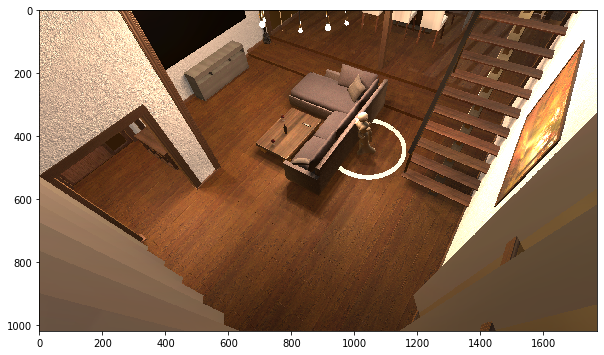

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       0.8846       |         1.9927        |         0.3059        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       4.846154       -1.603619
Mopping the floor                     4.846154        1.975900
Carry warm food                       4.230769       -0.751032
Carry cold food                       4.230769        3.636630
Carry drinks                          4.230769        3.153303
Carry small objects (plates, toys)    4.538462        3.398797
Carry big objects (tables, chairs)    4.615385        0.434162
Cleaning (Picking up stuff)           4.769231        3.210470

Scene number: 769


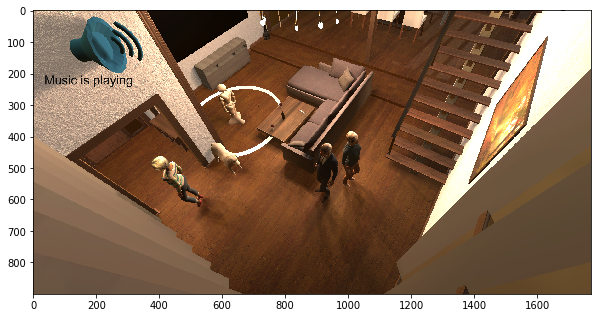

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.7536       |         2.0711        |         0.2237        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.533333       -2.100764
Mopping the floor                     2.933333        2.159345
Carry warm food                       2.733333       -0.472409
Carry cold food                       2.733333        3.329159
Carry drinks                          2.800000        3.161478
Carry small objects (plates, toys)    3.000000        3.294271
Carry big objects (tables, chairs)    2.533333       -0.279982
Cleaning (Picking up stuff)           3.133333        3.267664

Scene number: 432


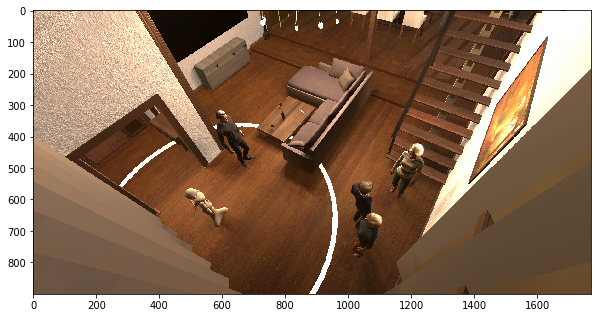

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       0.9114       |         1.8762        |         0.2318        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.142857       -1.509947
Mopping the floor                     2.142857        2.095269
Carry warm food                       3.785714       -0.703162
Carry cold food                       3.928571        4.010236
Carry drinks                          3.928571        3.581503
Carry small objects (plates, toys)    3.714286        3.796218
Carry big objects (tables, chairs)    2.285714        0.356207
Cleaning (Picking up stuff)           3.428571        3.455156

Scene number: 311


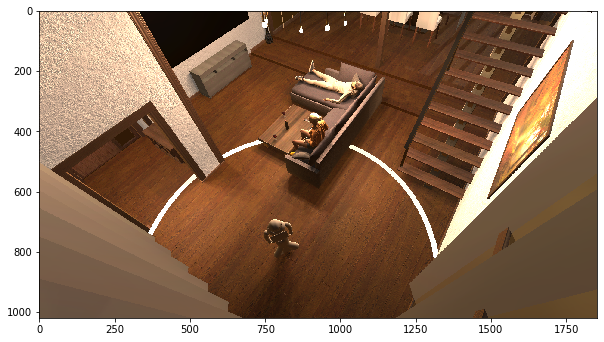

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.4119       |         2.0167        |         0.2856        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.666667       -2.040045
Mopping the floor                     3.333333        2.370616
Carry warm food                       3.600000       -0.538702
Carry cold food                       3.666667        3.923908
Carry drinks                          3.733333        3.634322
Carry small objects (plates, toys)    3.933333        3.942761
Carry big objects (tables, chairs)    3.066667        0.108487
Cleaning (Picking up stuff)           2.866667        3.470955

Scene number: 938


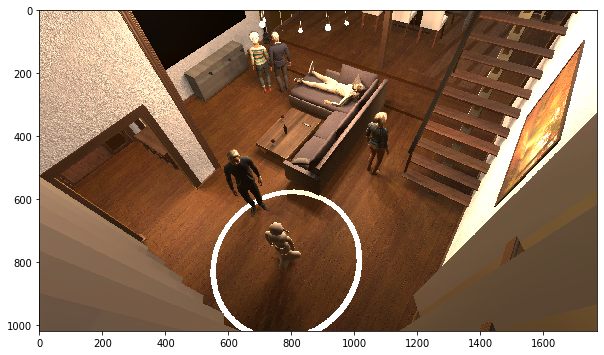

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.0464       |         1.7049        |         0.2688        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                         2.3750       -1.574604
Mopping the floor                       2.3750        2.381215
Carry warm food                         3.5625       -0.226847
Carry cold food                         3.7500        3.878818
Carry drinks                            3.8125        3.688587
Carry small objects (plates, toys)      3.5625        3.185015
Carry big objects (tables, chairs)      2.2500       -0.816522
Cleaning (Picking up stuff)             3.1250        3.576381

Scene number: 895


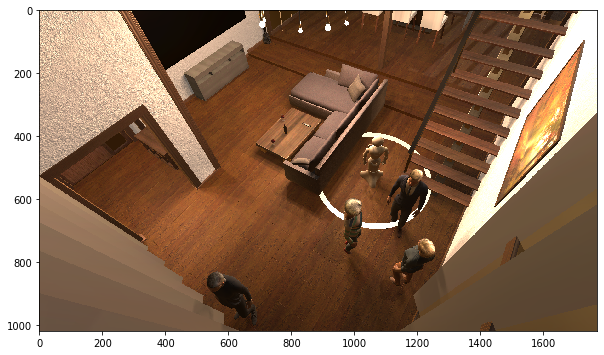

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.1484       |         1.4085        |         0.1312        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       1.714286       -1.124829
Mopping the floor                     2.071429        2.001505
Carry warm food                       3.714286       -0.652109
Carry cold food                       3.642857        3.174083
Carry drinks                          3.714286        2.787586
Carry small objects (plates, toys)    3.714286        2.502539
Carry big objects (tables, chairs)    1.785714       -0.401205
Cleaning (Picking up stuff)           3.500000        2.887875

Scene number: 921


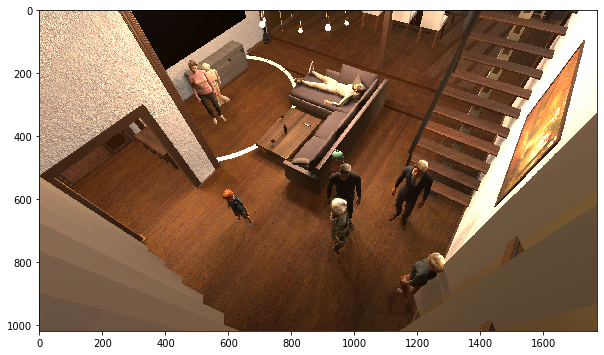

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       0.9857       |         1.4428        |         0.2704        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.266667       -1.241267
Mopping the floor                     2.266667        1.815965
Carry warm food                       3.600000       -0.530659
Carry cold food                       3.933333        3.611295
Carry drinks                          3.666667        3.764784
Carry small objects (plates, toys)    3.600000        2.488690
Carry big objects (tables, chairs)    2.333333       -0.924761
Cleaning (Picking up stuff)           3.466667        3.486712

Scene number: 650


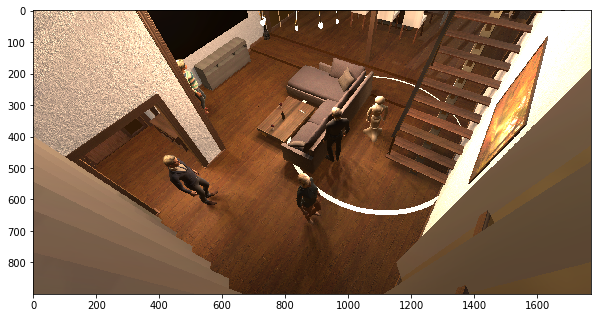

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.394        |         1.7365        |         0.1999        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.333333       -1.718310
Mopping the floor                     2.266667        2.228515
Carry warm food                       2.733333       -0.449559
Carry cold food                       2.866667        3.722876
Carry drinks                          2.866667        3.435993
Carry small objects (plates, toys)    2.866667        3.465299
Carry big objects (tables, chairs)    2.333333        0.014925
Cleaning (Picking up stuff)           3.200000        3.265007

Scene number: 878


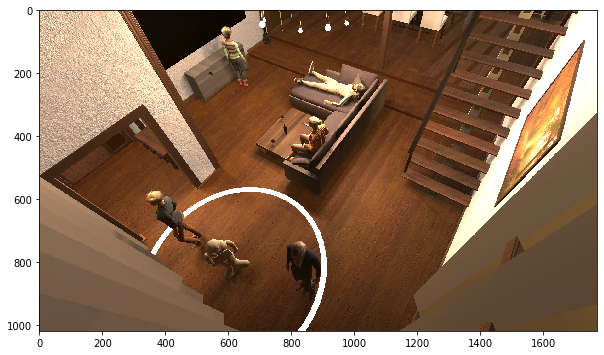

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.1218       |         1.7847        |         0.2122        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       1.923077       -1.907982
Mopping the floor                     2.000000        2.362674
Carry warm food                       3.461538       -0.438688
Carry cold food                       3.846154        3.766600
Carry drinks                          3.846154        3.422493
Carry small objects (plates, toys)    3.461538        3.222664
Carry big objects (tables, chairs)    1.923077       -0.009221
Cleaning (Picking up stuff)           3.000000        3.421824

Scene number: 526


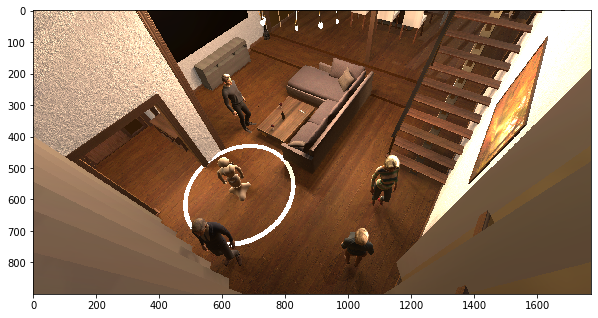

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       0.9514       |         1.7096        |         0.2344        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       3.000000       -2.128483
Mopping the floor                     3.000000        2.241198
Carry warm food                       3.777778       -0.737834
Carry cold food                       3.777778        3.787785
Carry drinks                          3.777778        3.075343
Carry small objects (plates, toys)    3.666667        3.109008
Carry big objects (tables, chairs)    2.666667       -0.453672
Cleaning (Picking up stuff)           3.444444        3.267299

Scene number: 918


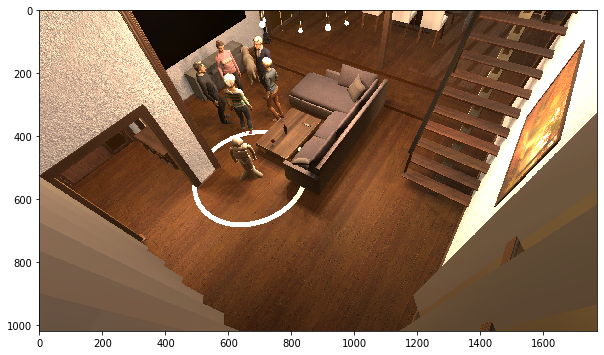

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.5871       |         1.6425        |         0.1449        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       1.583333       -1.694778
Mopping the floor                     1.916667        1.927369
Carry warm food                       3.333333       -0.610998
Carry cold food                       3.666667        3.218653
Carry drinks                          3.750000        2.774066
Carry small objects (plates, toys)    3.500000        2.786567
Carry big objects (tables, chairs)    2.250000       -0.570017
Cleaning (Picking up stuff)           3.500000        3.311248

Scene number: 974


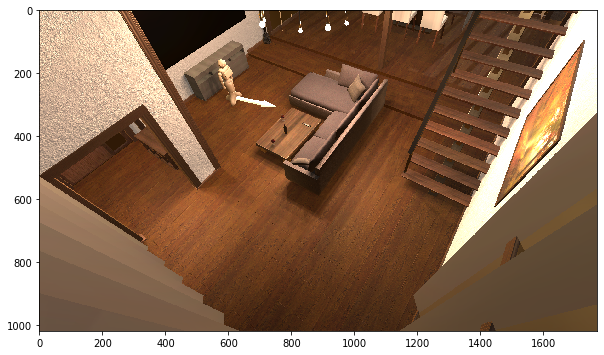

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.5071       |         1.2498        |         0.3006        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       4.533333        2.577083
Mopping the floor                     4.533333        2.681250
Carry warm food                       3.800000        3.108465
Carry cold food                       3.800000        3.774211
Carry drinks                          3.800000        2.590176
Carry small objects (plates, toys)    4.400000        3.587047
Carry big objects (tables, chairs)    4.266667       -0.341655
Starting conversation                 2.400000        3.432616

Scene number: 795


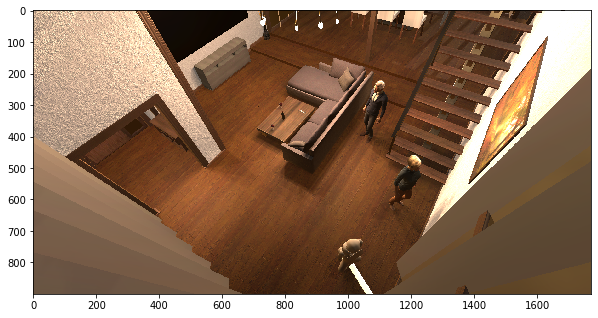

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       2.3736       |         1.1701        |         0.2122        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       3.071429        2.946906
Mopping the floor                     3.000000        2.369320
Carry warm food                       3.571429        3.137487
Carry cold food                       3.785714        3.549972
Carry drinks                          3.714286        2.381936
Carry small objects (plates, toys)    3.642857        3.537920
Carry big objects (tables, chairs)    3.142857       -0.084710
Starting conversation                 2.785714        3.062093

Scene number: 277


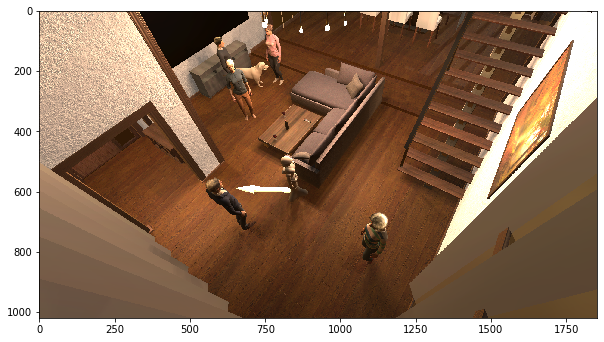

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.6067       |         1.2168        |         0.2105        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       3.263158        2.554622
Mopping the floor                     3.000000        1.823721
Carry warm food                       3.263158        3.052476
Carry cold food                       3.368421        3.506959
Carry drinks                          3.315789        2.623435
Carry small objects (plates, toys)    3.526316        3.599153
Carry big objects (tables, chairs)    2.947368       -0.470231
Starting conversation                 3.894737        3.058162

Scene number: 978


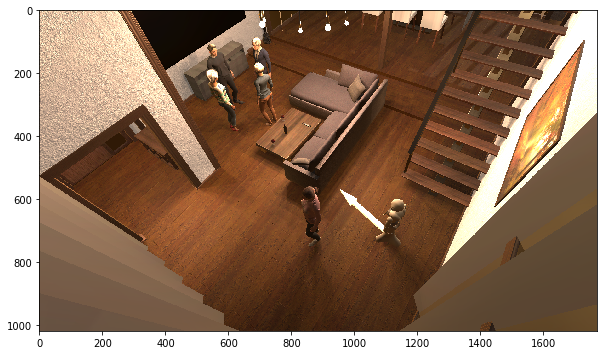

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.1988       |         1.1657        |         0.2119        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.266667        2.476202
Mopping the floor                     2.333333        2.444850
Carry warm food                       3.866667        3.000161
Carry cold food                       3.933333        3.818696
Carry drinks                          3.933333        2.718170
Carry small objects (plates, toys)    3.866667        3.615060
Carry big objects (tables, chairs)    2.333333       -0.098888
Starting conversation                 3.333333        3.206903

Scene number: 720


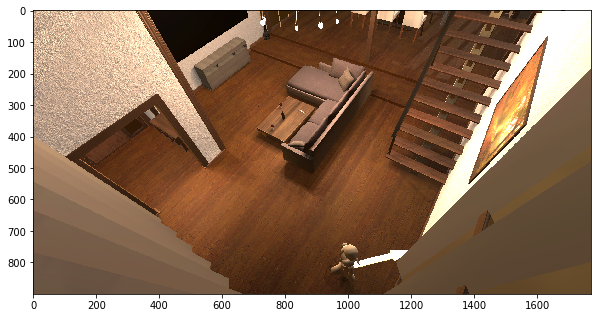

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.7411       |         1.2498        |         0.3006        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       3.714286        2.577083
Mopping the floor                     3.857143        2.681250
Carry warm food                       2.857143        3.108465
Carry cold food                       3.000000        3.774211
Carry drinks                          2.857143        2.590176
Carry small objects (plates, toys)    3.357143        3.587047
Carry big objects (tables, chairs)    2.928571       -0.341655
Starting conversation                 2.928571        3.432616

Scene number: 950


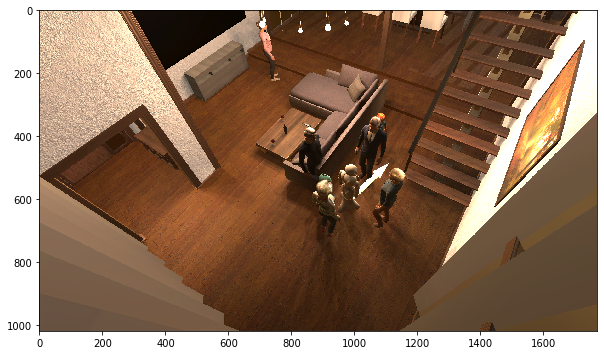

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.3393       |         1.4717        |         0.2101        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       1.200000        2.651847
Mopping the floor                     1.200000        2.314430
Carry warm food                       2.800000        2.956987
Carry cold food                       3.066667        3.442747
Carry drinks                          3.066667        2.489352
Carry small objects (plates, toys)    3.000000        3.611691
Carry big objects (tables, chairs)    1.333333       -0.106779
Starting conversation                 3.600000        3.552644

Scene number: 772


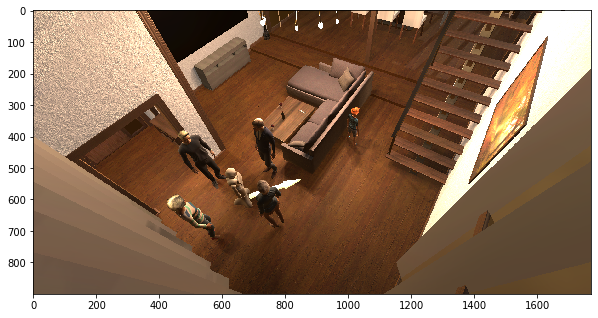

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.0114       |         1.2838        |         0.2162        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       2.000000        2.511143
Mopping the floor                     1.916667        1.977034
Carry warm food                       2.666667        2.865787
Carry cold food                       3.083333        3.434739
Carry drinks                          3.166667        2.263593
Carry small objects (plates, toys)    2.916667        3.438464
Carry big objects (tables, chairs)    1.500000       -0.171864
Starting conversation                 3.583333        3.160885

Scene number: 820


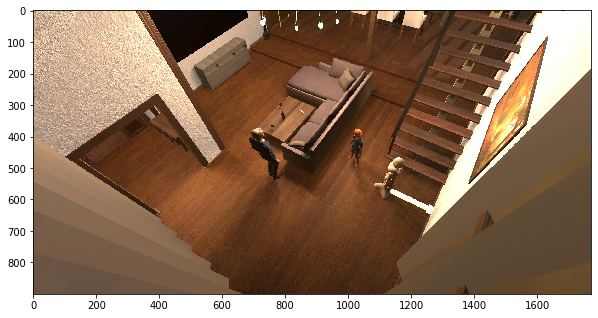

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.4776       |         1.2633        |         0.1916        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       4.230769        2.900386
Mopping the floor                     4.230769        2.337017
Carry warm food                       3.230769        2.987683
Carry cold food                       3.153846        3.312007
Carry drinks                          3.230769        2.067669
Carry small objects (plates, toys)    3.461538        3.460160
Carry big objects (tables, chairs)    3.076923       -0.004341
Starting conversation                 2.307692        3.026135

Scene number: 693


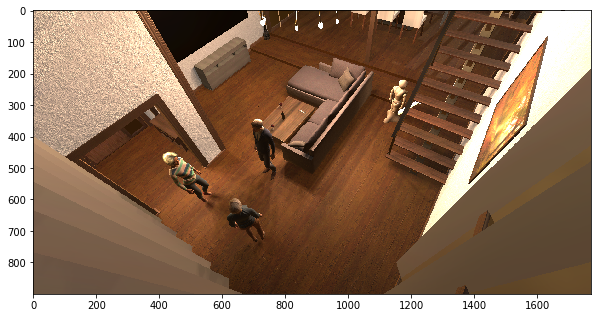

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.6405       |         1.1458        |         0.1373        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                       3.733333        2.140105
Mopping the floor                     4.133333        1.695560
Carry warm food                       3.933333        2.659078
Carry cold food                       3.933333        2.884831
Carry drinks                          3.866667        1.718625
Carry small objects (plates, toys)    3.733333        2.941672
Carry big objects (tables, chairs)    3.733333       -0.112975
Starting conversation                 2.600000        2.992222

Scene number: 497


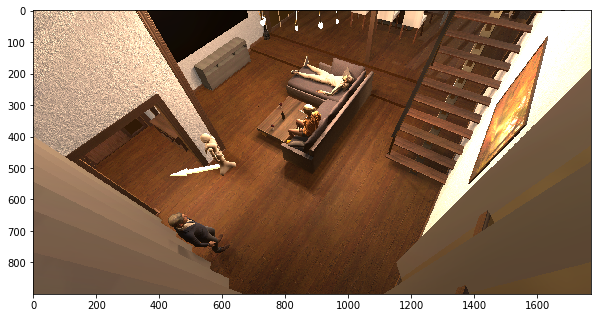

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.6172       |         1.1978        |         0.1973        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                         2.1250        2.725740
Mopping the floor                       2.4375        2.191796
Carry warm food                         3.5000        3.046271
Carry cold food                         3.6250        3.221589
Carry drinks                            3.6875        2.415314
Carry small objects (plates, toys)      3.6875        3.532030
Carry big objects (tables, chairs)      2.5000       -0.218337
Starting conversation                   2.6250        3.194686

Scene number: 525


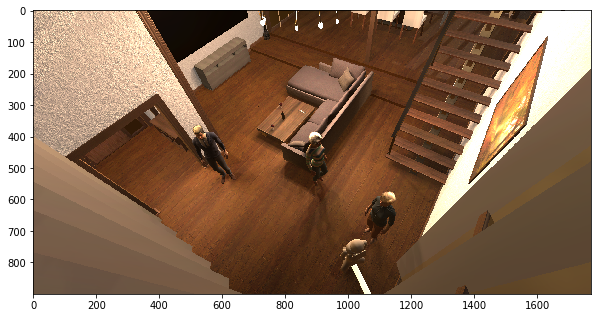

+--------------------+-----------------------+-----------------------+
| Variance in labels | Aleatoric uncertainty | Epistemic uncertainty |
+--------------------+-----------------------+-----------------------+
|       1.096        |         1.1638        |         0.2292        |
+--------------------+-----------------------+-----------------------+


Mean label  Predicted mean
Actions                                                       
Vacuum cleaning                          3.250        2.840526
Mopping the floor                        3.250        2.372304
Carry warm food                          3.625        3.065203
Carry cold food                          3.625        3.767889
Carry drinks                             3.625        2.667255
Carry small objects (plates, toys)       4.000        3.522928
Carry big objects (tables, chairs)       3.375       -0.780687
Starting conversation                    2.875        3.429166

In [11]:
print('Current model and task order: ', model_number, task_order)
# Print evaluation along with image
counter = 0
for action_type in test_scenes:
    for scene_index, scene in enumerate(action_type):
        print('Scene number:', scene)
        # Print image
        if features.loc[features['Stamp'] == scene].empty:
            image_path = '/Users/jonastjomsland/Dissertation/' + features.loc[features['Stamp'] == str(scene)]['File Path'].values[0]
        else:
            image_path = '/Users/jonastjomsland/Dissertation/' + features.loc[features['Stamp'] == scene]['File Path'].values[0]
        img = plt.imread(image_path)
        plt.figure(figsize = (10,12))
        plt.rcParams["axes.grid"] = False
        imgplot = plt.imshow(img)
        plt.show()
        # Create dataframe to view results:
        #eval_df = pd.DataFrame(columns= ['Mean label', 'Variance in labels', 'Predicted mean', 'Aleatoric uncertainty', 'Epistemic uncertainty'])
        eval_df = pd.DataFrame(columns= ['Mean label', 'Predicted mean'])        
        for column in eval_df:
            eval_df[column] = evaluation_dict[scene][column]
        eval_df.index = evaluation_dict[scene]['Actions']
        eval_df.index.name = 'Actions'
        # Print average Epistemic and Aleatoric uncertainty
        table = PrettyTable()
        table.field_names = ['Variance in labels', 'Aleatoric uncertainty', 'Epistemic uncertainty']
        table.add_row([np.round(np.mean(evaluation_dict[scene]['Variance in labels']), 4), np.round(np.mean(evaluation_dict[scene]['Aleatoric uncertainty']),4), np.round(np.mean(evaluation_dict[scene]['Epistemic uncertainty']), 4)])
        print(table)
        # Display predictions
        display(eval_df)
        counter += 1
        if counter > 10:
            counter = 0
            break